# Постановка задачи.
Для борьбы с оттоком клиентов из телекоммуникационной компании необходимо построить модель, которая определяет недовольных клиентов. Для удержания таких клиентов необходимо предложить им специальные условия.

Нам предоставили файлы с данными о клиентах:  
**contact** - информация о договорах клиентов (актуальна на 01.02.2020г.);    
**personal** - персональные данные клиентов;  
**internet** - информация об интернет-услугах;  
**phone** - информация об услугах телефонии.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
contact = pd.read_csv('/content/drive/My Drive/final_provider/contract.csv')
internet = pd.read_csv('/content/drive/My Drive/final_provider/internet.csv')
personal = pd.read_csv('/content/drive/My Drive/final_provider/personal.csv')
phone = pd.read_csv('/content/drive/My Drive/final_provider/phone.csv')

In [ ]:
# contact = pd.read_csv('/datasets/final_provider/contract.csv')
# internet = pd.read_csv('/datasets/final_provider/internet.csv')
# personal = pd.read_csv('/datasets/final_provider/personal.csv')
# phone = pd.read_csv('/datasets/final_provider/phone.csv')

# План решения задачи:
1. **Предобработка данных.** Посмотреть, что за данные нам даны, заполнить пропуски, скорректировать типы данных.
2. **Анализ данных.** Аналитически определить от чего зависит решение клиента уйти, и сделать предположения как это исправить.
3. **Построение модели.** Построение модели, которая бы выявляла клиентов, которые могут разорвать договор.


# Анализ данных.

## Изучим предоставленные данные.

### Таблица **contact**.

In [ ]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contact.columns = contact.columns.str.lower()

Таблица содержит следующие данные:  
**customerid** - ID клиента;  
**begindate** - дата заключения договора;  
**enddate** - дата расторжения договора;  
**type** - продолжительность заключенного договора;  
**paperlessbilling** - нужен ли бумажный счет на оплату;  
**paymentmethod** - способ оплаты;  
**monthlycharges** - ежемесячный платеж;  
**totalcharges** - общие расходы.


In [ ]:
print('Общая информация о таблице:')
print()
contact.info()

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
print('Пропущенные значения:')
print()
contact.isna().sum()

Пропущенные значения:



customerid          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

In [ ]:
print('Количество дублирующихся значений:', contact.duplicated().sum())
print('Количество дублирующихся ID клиента:', contact.duplicated(subset='customerid').sum())

Количество дублирующихся значений: 0
Количество дублирующихся ID клиента: 0


In [ ]:
print('Варианты paperlessbilling:\n', contact['paperlessbilling'].unique().reshape(-1,1))

Варианты paperlessbilling:
 [['Yes']
 ['No']]


In [ ]:
print('Варианты способов оплаты:\n', contact['paymentmethod'].unique().reshape(-1,1))

Варианты способов оплаты:
 [['Electronic check']
 ['Mailed check']
 ['Bank transfer (automatic)']
 ['Credit card (automatic)']]


Рассмотрим столбец общих расходов.  
У него должен быть вещественный тип данных, однако сейчас это не так.  
Посмотрим какие там данные.

In [ ]:
contact['totalcharges'].value_counts()

           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
7746.7      1
4895.1      1
266.95      1
3775.85     1
1663.5      1
Name: totalcharges, Length: 6531, dtype: int64

В столбце totalcharges есть 11 не заполненных значений.  
Посмотрим, что это за клиенты.

In [ ]:
contact[contact['totalcharges'] == ' ']

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Видно, что это клиенты у которых договор начинает действовать с 1 февраля 2020г.  
Нам предоставили данные до этого месяца, поэтому общие расходы таких клиентов можно приравнять к расходам за месяц.

In [ ]:
contact.loc[contact['totalcharges'] == ' ', 'totalcharges'] = contact.loc[contact['totalcharges'] == ' ', 'monthlycharges']

Преобразуем типы данных в некоторых столбцах:  
**begindate** - изменим тип на datetime;  
**enddate** - уберем информацию о времени, в значениях дат;  
**totalcharges** - изменим тип на float.

In [ ]:
contact['begindate'] = pd.to_datetime(contact['begindate'])

In [ ]:
temp_contact = contact[contact['enddate'] != 'No'].copy()
temp_contact['enddate'] = pd.to_datetime(temp_contact['enddate'])
contact.loc[contact['enddate'] != 'No', 'enddate'] = temp_contact['enddate'].astype('str')

In [ ]:
contact['totalcharges'] = contact['totalcharges'].astype('float')

В итоге получили таблицу:

In [ ]:
contact.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Добавим информацию о том сколько месяцев клиент пользовался услугами оператора, год и месяц открытия и закрытия договора

In [ ]:
for i,_ in temp_contact.iterrows():
  temp_contact.loc[i, 'totaltime'] = len(pd.date_range(start=temp_contact.loc[i,'begindate'], 
                                                       end=temp_contact.loc[i,'enddate'], 
                                                       freq='M'))

In [ ]:
temp_contact['endmonth'] = pd.DatetimeIndex(temp_contact['enddate']).month
temp_contact['endyear'] = pd.DatetimeIndex(temp_contact['enddate']).year

In [ ]:
contact.loc[contact['enddate'] != 'No', 'totaltime'] = temp_contact['totaltime']
contact.loc[contact['enddate'] != 'No', 'endmonth'] = temp_contact['endmonth']
contact.loc[contact['enddate'] != 'No', 'endyear'] = temp_contact['endyear']

In [ ]:
contact.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,totaltime,endmonth,endyear
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,NaN,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,NaN,NaN,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2.0,12.0,2019.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2.0,11.0,2019.0


In [ ]:
for i,_ in contact[contact['enddate'] == 'No'].iterrows():
  contact.loc[i, 'totaltime'] = len(pd.date_range(start=contact.loc[i,'begindate'], 
                                                       end=pd.to_datetime('2020-02-01'), 
                                                       freq='M'))

In [ ]:
contact.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,totaltime,endmonth,endyear
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,NaN,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,34.0,NaN,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2.0,12.0,2019.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,45.0,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2.0,11.0,2019.0


In [ ]:
contact['beginmonth'] = pd.DatetimeIndex(contact['begindate']).month
contact['beginyear'] = pd.DatetimeIndex(contact['begindate']).year

In [ ]:
contact.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,totaltime,endmonth,endyear,beginmonth,beginyear
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,NaN,NaN,1,2020
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,34.0,NaN,NaN,4,2017
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2.0,12.0,2019.0,10,2019
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,45.0,NaN,NaN,5,2016
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2.0,11.0,2019.0,9,2019


Так же добавим информацию о среднем расходе клиента:

In [ ]:
contact = contact[contact['begindate'] != '2020-02-01'].reset_index()

In [ ]:
contact['averagecharges'] = contact['totalcharges'] / contact['totaltime']

### Таблица **personal**.

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.columns = personal.columns.str.lower()

Таблица содержит следующие данные:  
**customerid** - ID клиента;  
**gender** - пол клиента;  
**seniorcitizen** - является ли клиент пенсионером;  
**partner** - женат/замужем;  
**dependents** - есть ли дети.

In [ ]:
print('Общая информация о таблице:')
print()
personal.info()

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
print('Пропущенные значения:')
print()
personal.isna().sum()

Пропущенные значения:



customerid       0
gender           0
seniorcitizen    0
partner          0
dependents       0
dtype: int64

In [ ]:
print('Количество дублирующихся значений:', personal.duplicated().sum())
print('Количество дублирующихся ID клиента:', personal.duplicated(subset='customerid').sum())

Количество дублирующихся значений: 0
Количество дублирующихся ID клиента: 0


In [ ]:
for col in personal.columns[1:]:
  print('Варианты', col, ':\n', personal[col].unique().reshape(-1,1))
  print()

Варианты gender :
 [['Female']
 ['Male']]

Варианты seniorcitizen :
 [[0]
 [1]]

Варианты partner :
 [['Yes']
 ['No']]

Варианты dependents :
 [['No']
 ['Yes']]



### Таблица **internet**.

In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.columns = internet.columns.str.lower()

Таблица содержит следующие данные:  
**customerid** - ID клиента;  
**internetservice** - способ интернет соединения;  
**onlinesecurity** - подключена ли блокировка небезопасных сайтов;  
**onlinebackup** - подключено ли облачное хранилище;  
**deviceprotection** - подключен ли антивирус;  
**techsupport** - есть ли выделенная линия технической поддержки;  
**streamingtv** - подключено ли стриминговое телевидение;  
**streamingmovies** - подключен ли каталог фильмов.

In [ ]:
print('Общая информация о таблице:')
print()
internet.info()

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
print('Количество дублирующихся значений:', internet.duplicated().sum())
print('Количество дублирующихся ID клиента:', internet.duplicated(subset='customerid').sum())

Количество дублирующихся значений: 0
Количество дублирующихся ID клиента: 0


In [ ]:
for col in internet.columns[1:]:
  print('Варианты', col, ':\n', internet[col].unique().reshape(-1,1))
  print()

Варианты internetservice :
 [['DSL']
 ['Fiber optic']]

Варианты onlinesecurity :
 [['No']
 ['Yes']]

Варианты onlinebackup :
 [['Yes']
 ['No']]

Варианты deviceprotection :
 [['No']
 ['Yes']]

Варианты techsupport :
 [['No']
 ['Yes']]

Варианты streamingtv :
 [['No']
 ['Yes']]

Варианты streamingmovies :
 [['No']
 ['Yes']]



### Таблица **phone**.

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.columns = phone.columns.str.lower()

Таблица содержит следующие данные:  
**customerid** - ID клиента;   
**multiplelines** - подключена ли возможность подключения телефона к нескольким линиям одновременно.

In [ ]:
print('Общая информация о таблице:')
print()
phone.info()

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
print('Количество дублирующихся значений:', internet.duplicated().sum())
print('Количество дублирующихся ID клиента:', internet.duplicated(subset='customerid').sum())

Количество дублирующихся значений: 0
Количество дублирующихся ID клиента: 0


In [ ]:
for col in phone.columns[1:]:
  print('Варианты', col, ':\n', phone[col].unique().reshape(-1,1))
  print()

Варианты multiplelines :
 [['No']
 ['Yes']]



### Вывод.

Мы рассмотрели предоставленные таблицы. Посмотрели по каким параметрам делалась выгрузка и какие значения они принимают.  
Таблицу **contact** привели в корректный вид: заполнили пропуска и изменили тип данных, где это необходимо.

## Исследовательский анализ.

Для удобства сделаем одну общую таблицу, в которую сведем все данные о клиентах. Если у клиента нет информации о пользовании услугой, то пропущенное значение заменим на 'No'.

In [ ]:
general = contact.copy()
general = general.merge(personal, on='customerid', how='left')
general = general.merge(internet, on='customerid', how='left')
general = general.merge(phone, on='customerid', how='left')

Добавим столбец, который будет индикатором того ушел клиент или нет.

In [ ]:
general['target'] = (general['enddate'] != 'No') * 1

In [ ]:
pd.set_option('display.max_columns', 50)
general = general.fillna('No')
general.head(3)

,index,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,totaltime,endmonth,endyear,beginmonth,beginyear,averagecharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target
0,0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,No,No,1,2020,29.850000,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
1,1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,34.0,No,No,4,2017,55.573529,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2.0,12,2019,10,2019,54.075000,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1


Сравним общее число клиентов с числом ушедших клиентов по всем признакам.

In [ ]:
general.columns

Index(['index', 'customerid', 'begindate', 'enddate', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'totaltime', 'endmonth', 'endyear', 'beginmonth', 'beginyear',
       'averagecharges', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
       'target'],
      dtype='object')

In [ ]:
columns = ['enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'totaltime', 'endmonth', 'endyear', 'beginmonth', 
       'beginyear', 'gender', 'seniorcitizen', 'partner', 'dependents', 
       'internetservice', 'onlinesecurity', 'onlinebackup', 
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'multiplelines']

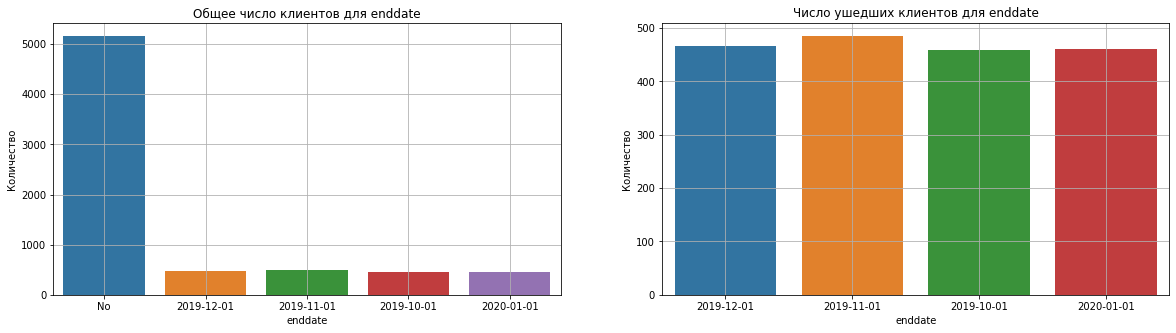

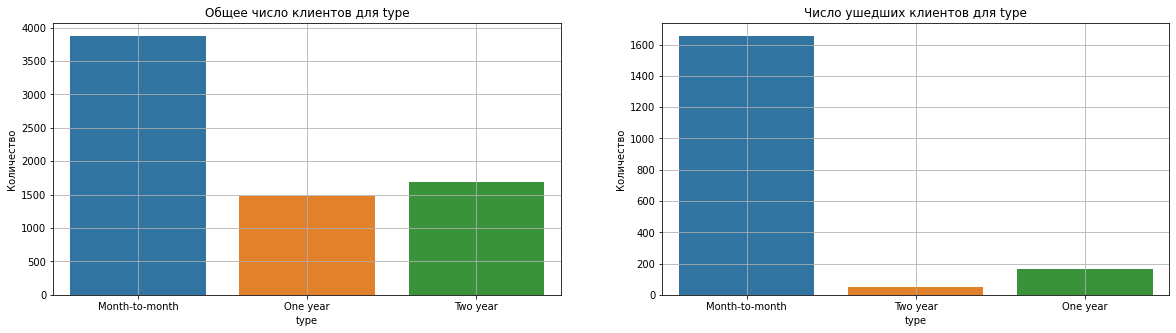

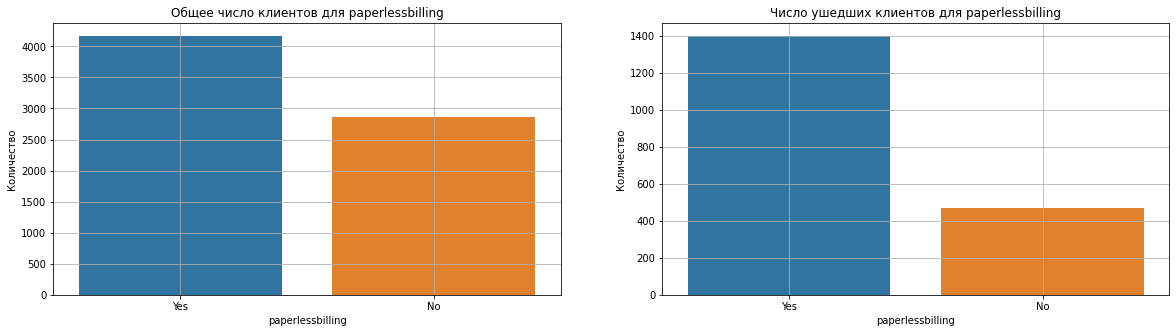

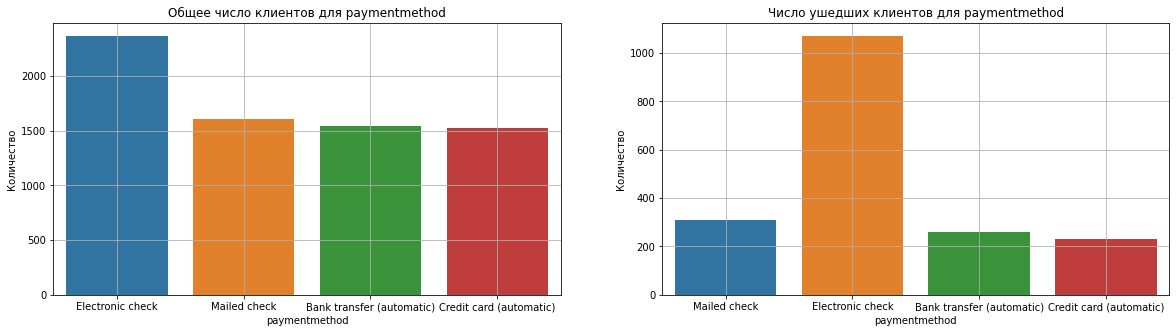

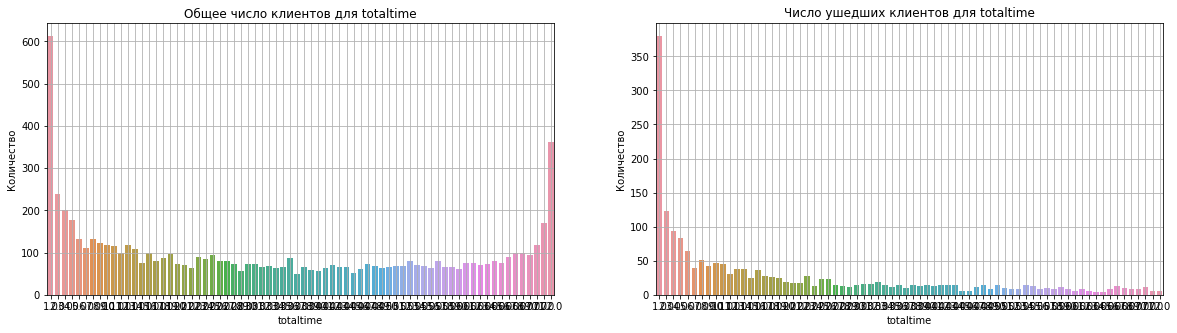

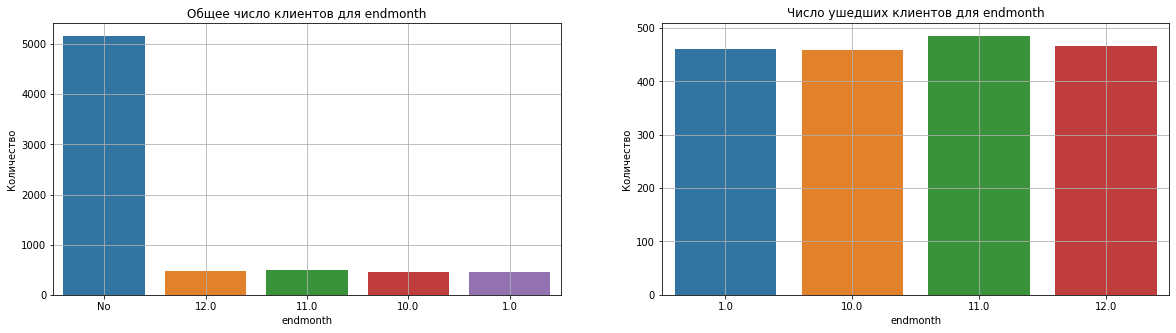

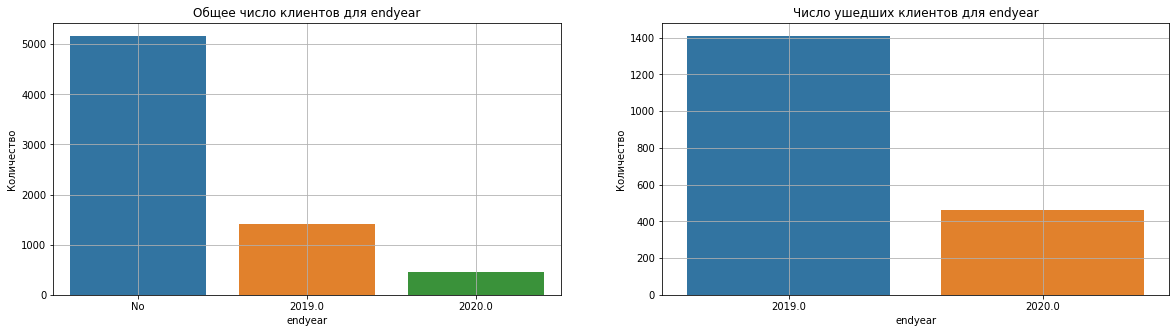

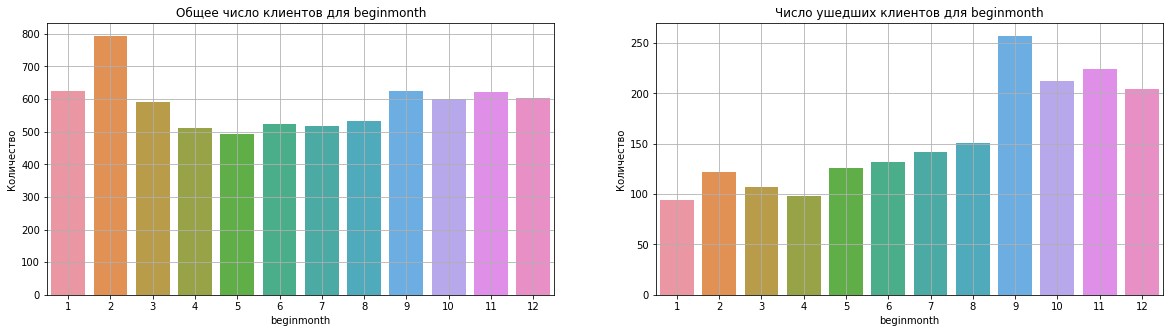

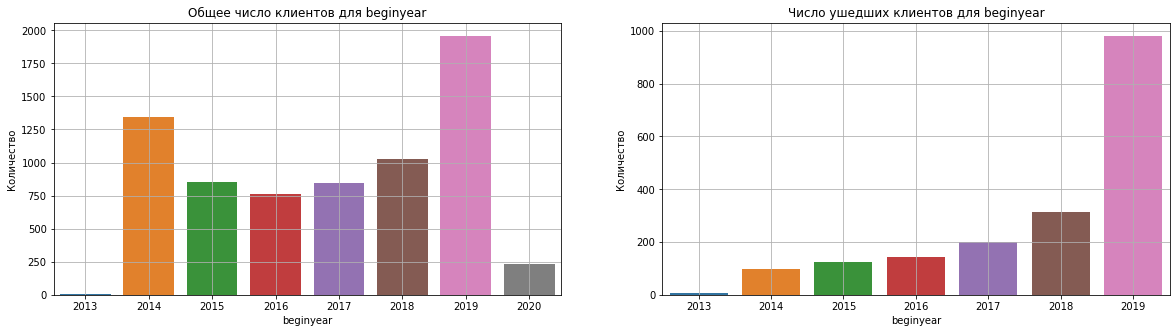

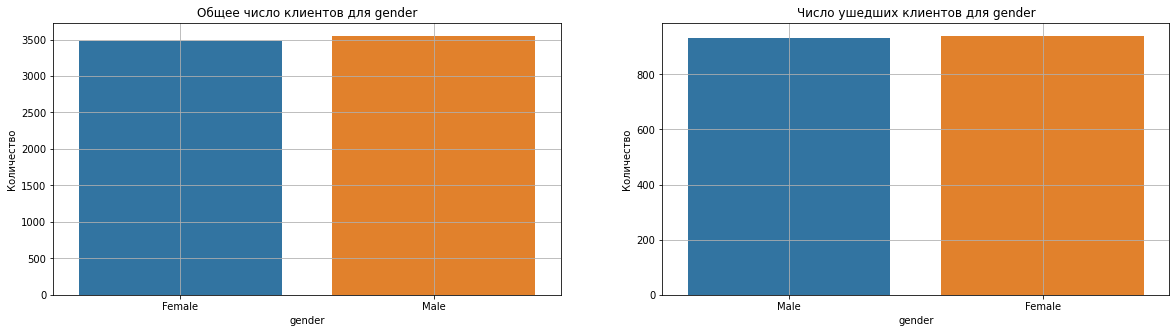

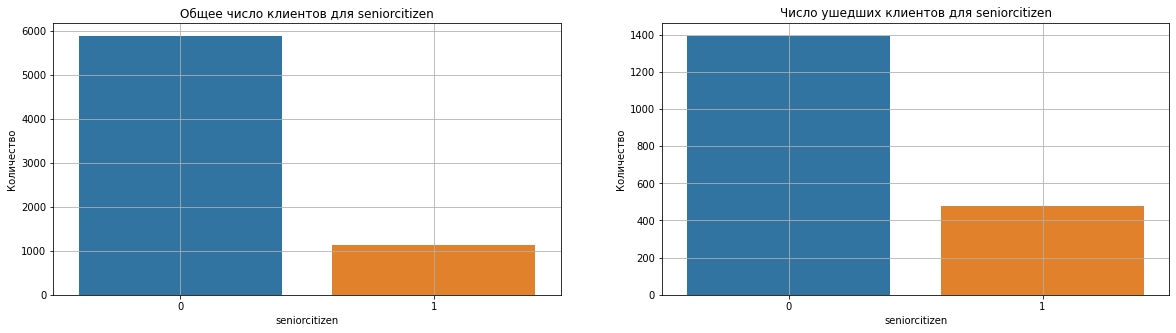

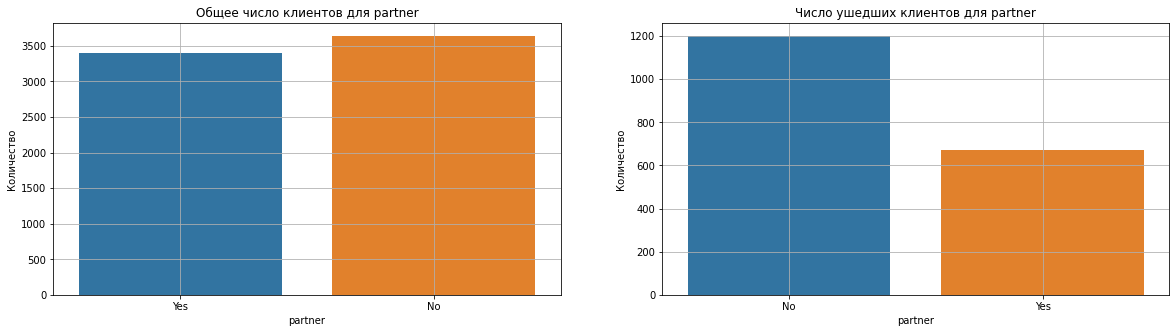

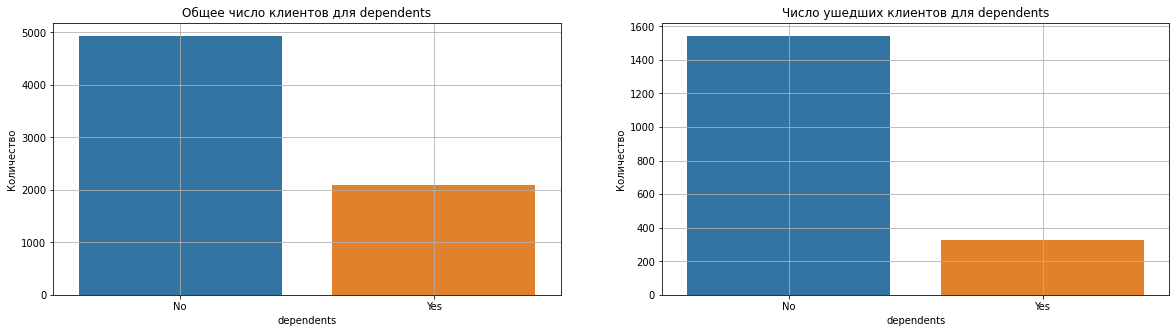

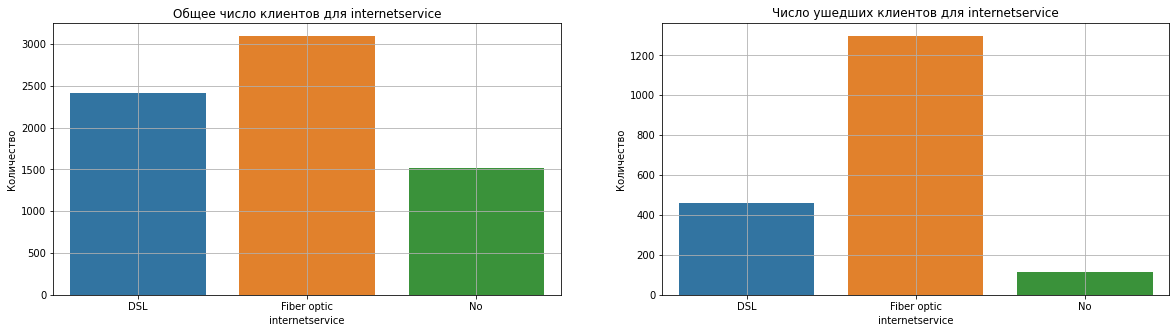

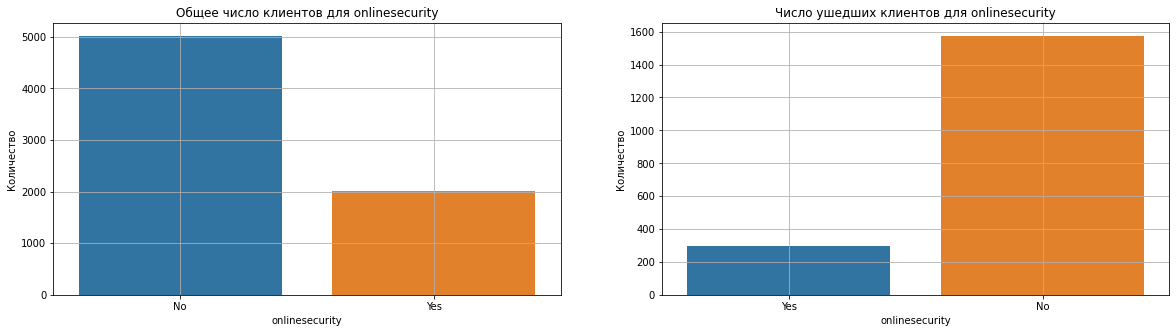

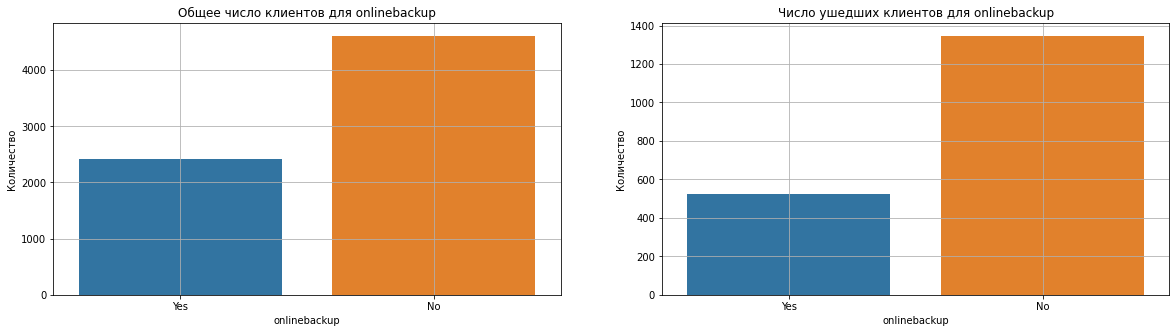

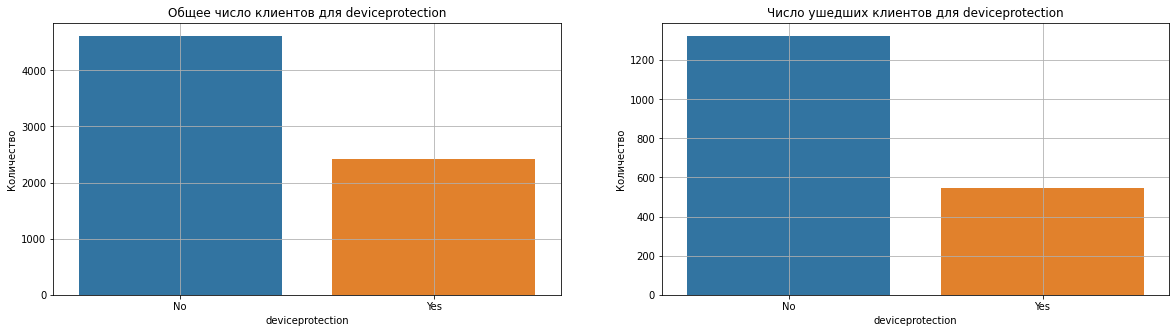

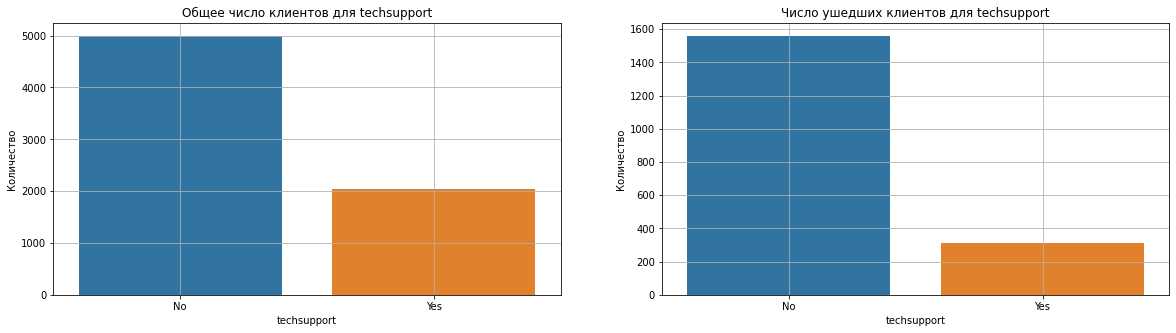

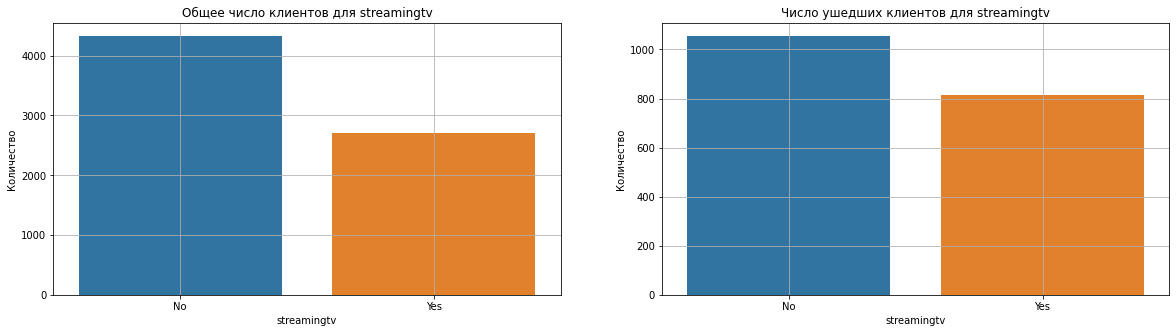

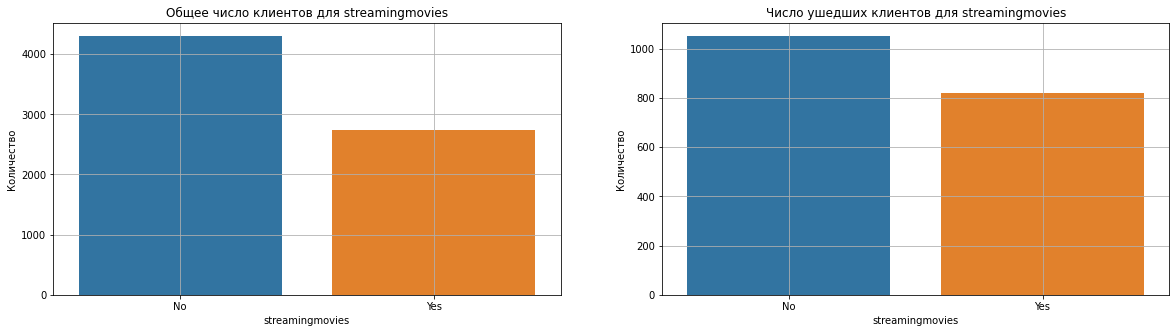

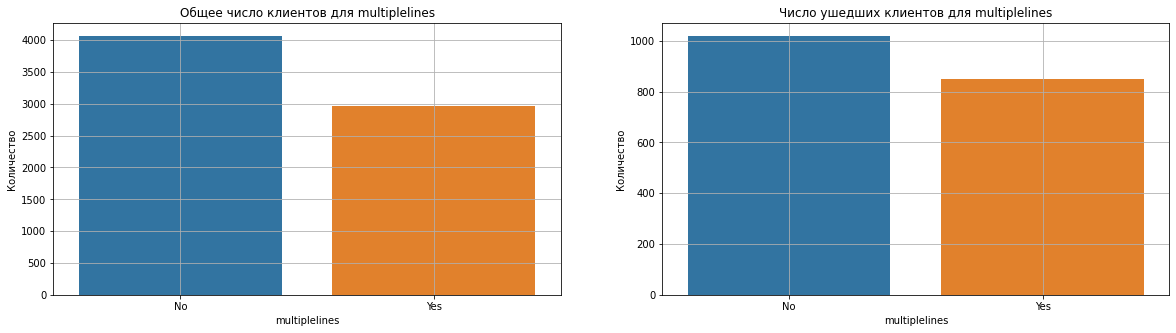

In [ ]:
for col in columns:
  plt.figure(figsize = (20,5))
  plt.subplot(1, 2, 1)
  sns.countplot(x=col, data=general)
  plt.xlabel(col)
  plt.ylabel('Количество')
  plt.title('Общее число клиентов для ' + str(col))
  plt.grid(True)
  plt.subplot(1, 2, 2)
  sns.countplot(x=col, data=general[general['target'] == 1])
  plt.xlabel(col)
  plt.ylabel('Количество')
  plt.title('Число ушедших клиентов для ' + str(col))
  plt.grid(True)
  plt.show()

In [ ]:
columns_numeric = ['monthlycharges', 'totalcharges', 
                   'totaltime', 'averagecharges']

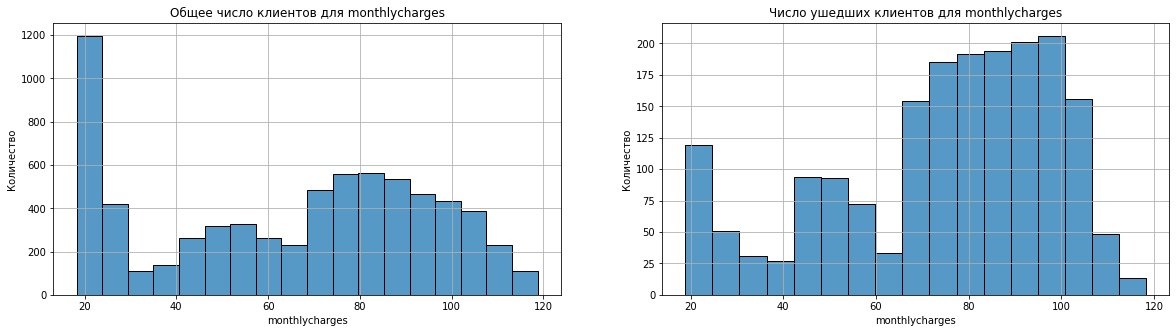

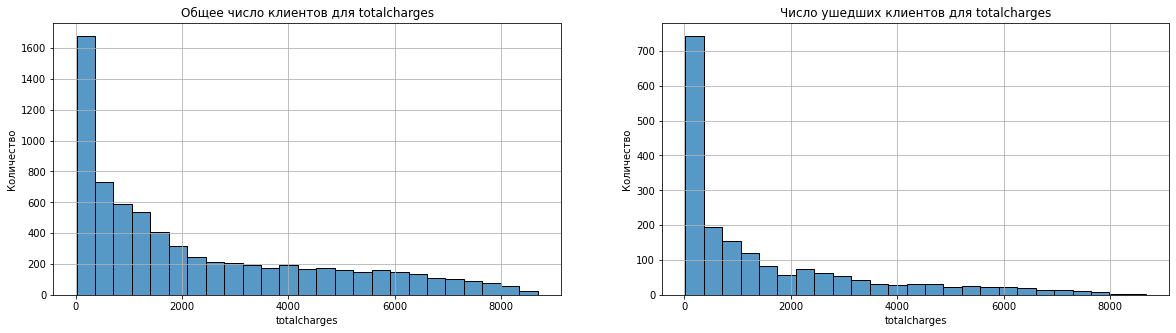

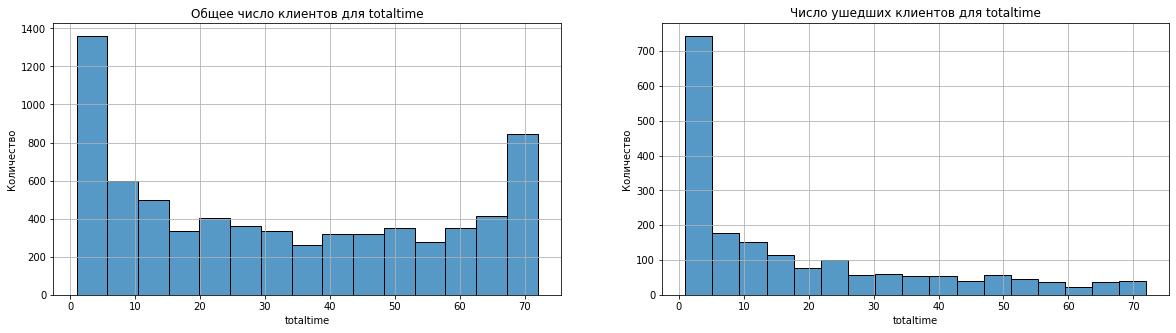

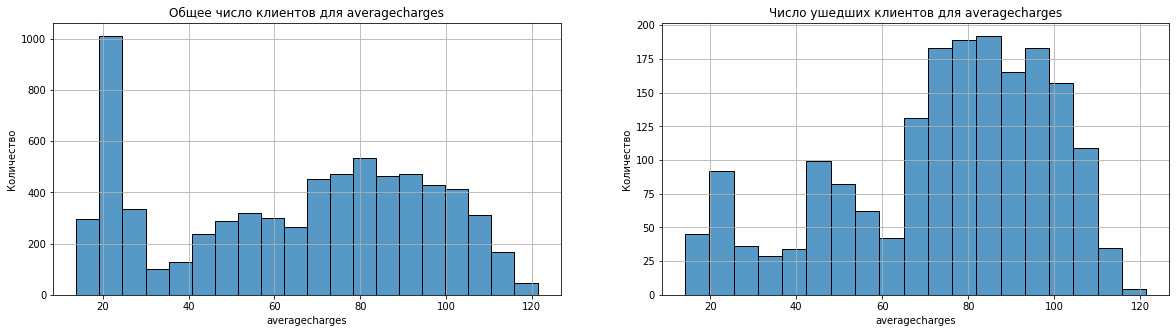

In [ ]:
for col in columns_numeric:
  plt.figure(figsize = (20,5))
  plt.subplot(1, 2, 1)
  sns.histplot(general[col])
  plt.xlabel(col)
  plt.ylabel('Количество')
  plt.title('Общее число клиентов для ' + str(col))
  plt.grid(True)
  plt.subplot(1, 2, 2)
  sns.histplot(general[general['target'] == 1][col])
  plt.xlabel(col)
  plt.ylabel('Количество')
  plt.title('Число ушедших клиентов для ' + str(col))
  plt.grid(True)
  plt.show()

Посмотрим, как параметры корреклируют между собой.

In [ ]:
general.corr()

,index,monthlycharges,totalcharges,totaltime,beginmonth,beginyear,averagecharges,seniorcitizen,target
index,1.000000,-0.012938,0.001820,0.006801,0.008021,-0.008539,-0.012462,0.008057,0.010133
monthlycharges,-0.012938,1.000000,0.651065,0.246862,-0.019613,-0.263086,0.996237,0.219874,0.192858
totalcharges,0.001820,0.651065,1.000000,0.825880,-0.196624,-0.819304,0.650915,0.102411,-0.199484
totaltime,0.006801,0.246862,0.825880,1.000000,-0.233515,-0.987441,0.246198,0.015683,-0.354049
beginmonth,0.008021,-0.019613,-0.196624,-0.233515,1.000000,0.084872,-0.020484,0.028569,0.180522
beginyear,-0.008539,-0.263086,-0.819304,-0.987441,0.084872,1.000000,-0.262235,-0.027386,0.293770
averagecharges,-0.012462,0.996237,0.650915,0.246198,-0.020484,-0.262235,1.000000,0.217616,0.192033
seniorcitizen,0.008057,0.219874,0.102411,0.015683,0.028569,-0.027386,0.217616,1.000000,0.150541
target,0.010133,0.192858,-0.199484,-0.354049,0.180522,0.293770,0.192033,0.150541,1.000000


Видно, что средний платеж и ежемесячный платеж имеют линейную зависимость, поэтому при построении модели, выберем только один из этих параметров.

### Вывод.
Из графиков видно, какие признаки больше влияют на решение клиента уйти. Так, например, можно выделить:  
**type** – большая часть клиентов уходит с договором *Month-to-month*;  
**paymentmothod** – много клиентов разрывает договор со способом оплаты *electronic check*, существующим клиентам с такой системой оплаты можно предложить другую;  
**beginyear** – видна тенденция, что уходят новые клиенты, которые заключили договор в последние годы;  
**partner** – отсутствие жены/мужа сильнее влияет на решение клиента уйти;   
**internetservice** – клиентам, которые пользуются *Fiber optic*, больше не нравится качество услуг, чем клиентам с *DSL*;  
**onlinesecurity** – этот параметр, так же сильно влияет на решение клиента уйти, у кого нет защиты намного чаще других разрывают договора;  
**onlinebackup** - отсутствие бекапа так же негативно сказывается на решении клиента остаться;  
**techsupport** - аналогично с выделенной линией тех. поддержки;  
**monthcharges** - так же можно обратить внимание на ежемесячный платеж, в основном уходят те клиенты, у которых ежемесячный платеж в интервале 70-110.  

# Построение модели.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

Для начала сразу разделим данные на тестовую и тренировочную выборку. В конце работы будем проводить финальную оценку модели на тестовой выборке.

In [ ]:
general_train, general_test = train_test_split(general, 
                                               test_size=0.2, 
                                               stratify = general['target'], 
                                               random_state=4)

In [ ]:
print('Баланс классов:', general_train['target'].mean())

Баланс классов: 0.2657777777777778


Классы у нас разбалансированы.   
В качестве основной метрики будем использовать ROC-AUC. Дополнтельной метрикой будет accuracy, так как она более понятно описывает качество работы алгоритма.

Рассмотрим несколько моделей обучения и выберем наиболее подходящую для нашей задачи. Оценивать модели будем на кроссвалидации.

В модели будем использовать следующе признаки:

In [ ]:
columns = ['type', 'paperlessbilling', 'paymentmethod', 
           'gender','monthlycharges', 'totalcharges',
           'seniorcitizen', 'partner', 'dependents',
           'internetservice', 'onlinesecurity', 
           'onlinebackup', 'deviceprotection',
           'techsupport', 'streamingtv', 'streamingmovies',
           'multiplelines', 'totaltime']

Проведем кодирование категориальных признаков и создадим датафрейм признаков для модели.

In [ ]:
data_type = pd.DataFrame(data=general_train[columns].dtypes, columns=['type'])
columns_categor = data_type[data_type['type'] == 'object'].index
columns_numeric = data_type[data_type['type'] != 'object'].index

In [ ]:
columns_categor

Index(['type', 'paperlessbilling', 'paymentmethod', 'gender', 'partner',
       'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'multiplelines'],
      dtype='object')

In [ ]:
columns_numeric

Index(['monthlycharges', 'totalcharges', 'seniorcitizen', 'totaltime'], dtype='object')

In [ ]:
encoder = OneHotEncoder(sparse=False)
train_categor = encoder.fit_transform(general_train[columns_categor])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_numeric = scaler.fit_transform(general_train[columns_numeric])

In [ ]:
X_train_transform = np.hstack((train_categor, train_numeric))
y_train = general_train['target']

## RandomForestClassifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
result = pd.DataFrame(columns=['model', 'roc-auc'])

Для модели случайного леса качество модели в основном зависит от количества деревьев, поэтому сразу зададим большое число деревьев, чтобы посмотреть на наилучший показатель модели и чтобы не заниматься перебором гиперпараметров.

In [ ]:
model = RandomForestClassifier(random_state=4, n_estimators=1000)
cvs = cross_val_score(model, X_train_transform, y_train, scoring='roc_auc', cv=5)

In [ ]:
result.loc[0, 'model'] = 'RandomForestClassifier'
result.loc[0, 'roc-auc'] = cvs.mean()
result

,model,roc-auc
0,RandomForestClassifier,0.822293


## LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

В модели LGBMClassifier рассмотрим несколько вариантов скорости обучения

In [ ]:
model = LGBMClassifier(random_state=4, learning_rate=0.1, n_estimators=1000)
cvs = cross_val_score(model, X_train_transform, y_train, scoring='roc_auc', cv=5)
result.loc[1, 'model'] = 'LGBMClassifier_lr_0.1'
result.loc[1, 'roc-auc'] = cvs.mean()

In [ ]:
model = LGBMClassifier(random_state=4, learning_rate=0.01, n_estimators=1000)
cvs = cross_val_score(model, X_train_transform, y_train, scoring='roc_auc', cv=5)
result.loc[2, 'model'] = 'LGBMClassifier_lr_0.01'
result.loc[2, 'roc-auc'] = cvs.mean()

In [ ]:
model = LGBMClassifier(random_state=4, learning_rate=0.001, n_estimators=1000)
cvs = cross_val_score(model, X_train_transform, y_train, scoring='roc_auc', cv=5)
result.loc[3, 'model'] = 'LGBMClassifier_lr_0.001'
result.loc[3, 'roc-auc'] = cvs.mean()

In [ ]:
result

,model,roc-auc
0,RandomForestClassifier,0.822293
1,LGBMClassifier_lr_0.1,0.811792
2,LGBMClassifier_lr_0.01,0.8342
3,LGBMClassifier_lr_0.001,0.84048


При использовании LGBMClassifier метрика ROC-AUC получается выше. Наибольшее значение получется при скорости обучения равной 0.001   
Рассмотрим эту модель получше.  
Попробуем изменять максимальное количество листьев.

In [ ]:
result_leaves = pd.DataFrame()
for i in range(1, 10):
  model = LGBMClassifier(random_state=4, learning_rate=0.001, 
                         n_estimators=10000, num_leaves=5*i)
  result_leaves.loc[i, 'num_leaves'] = 5 * i
  result_leaves.loc[i, 'roc-auc'] = cross_val_score(model, X_train_transform,
                                                    y_train, scoring='roc_auc', 
                                                    cv=5).mean()
result_leaves

,num_leaves,roc-auc
1,5.0,0.847921
2,10.0,0.845242
3,15.0,0.841391
4,20.0,0.839363
5,25.0,0.835490
6,30.0,0.834629
7,35.0,0.832843
8,40.0,0.830489
9,45.0,0.830050


Наибольшее значение получается при num_leaves = 5.  
В итоге получили модель:  
*LGBMClassifier(learning_rate=0.001, n_estimators=10000, num_leaves=5)*

Так как наш целефой показатель не сбалансирован, посмотрим как повлияет на метрику upsample и downsample.

In [ ]:
from sklearn.utils import shuffle

In [ ]:
X_zero = X_train_transform[y_train == 0]
X_one = X_train_transform[y_train == 1]
y_zero = y_train[y_train == 0]
y_one = y_train[y_train == 1]

X_zero_df = pd.DataFrame(X_zero)
X_one_df = pd.DataFrame(X_one)

N = int(round(general_train[general_train['target'] == 0]['target'].count() / 
          general_train[general_train['target'] == 1]['target'].count()))

X_train_transform_upsample = pd.concat([X_zero_df] + [X_one_df]*N)
y_train_upsample = pd.concat([y_zero] + [y_one]*N)

X_train_transform_upsample, y_train_upsample = shuffle(X_train_transform_upsample, 
                                                       y_train_upsample, 
                                                       random_state=4)

In [ ]:
N = (general_train[general_train['target'] == 1]['target'].count() / 
    general_train[general_train['target'] == 0]['target'].count())

X_train_transform_downsample = pd.concat([X_zero_df.sample(frac=N, random_state = 4)] 
                                         + [X_one_df])
y_train_downsample = pd.concat([y_zero.sample(frac=N, random_state = 4)] 
                               + [y_one])

X_train_transform_downsample, y_train_downsample = shuffle(X_train_transform_downsample, 
                                                           y_train_downsample, 
                                                           random_state=4)

In [ ]:
result_sampling = pd.DataFrame()
model = LGBMClassifier(random_state=4, learning_rate=0.001, n_estimators=10000, num_leaves=5)
result_sampling.loc[0, 'sample'] = 'upsample'
result_sampling.loc[0, 'roc-auc'] = cross_val_score(model, 
                                                    X_train_transform_upsample, 
                                                    y_train_upsample, 
                                                    scoring='roc_auc', 
                                                    cv=5).mean()
                                                    
result_sampling.loc[1, 'sample'] = 'downsample'
result_sampling.loc[1, 'roc-auc'] = cross_val_score(model, 
                                                    X_train_transform_downsample, 
                                                    y_train_downsample, 
                                                    scoring='roc_auc', 
                                                    cv=5).mean()


In [ ]:
result_sampling

,sample,roc-auc
0,upsample,0.858652
1,downsample,0.844956


In [ ]:
model = LGBMClassifier(random_state=4, learning_rate=0.001, n_estimators=10000, num_leaves=5)
model.fit(X_train_transform_upsample, y_train_upsample)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=5, objective=None,
               random_state=4, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Посмотрим, наскаолько сильно каждый признак влияет на результат модели.

In [ ]:
feature_columns = ['type_Month-to-month', 'type_One year', 'type_Two year',
                   'paperlessbilling-No', 'paperlessbilling_Yes',
                   'paymentmethod_Bank transfer (automatic)', 
                   'paymentmethod_Credit card (automatic)',
                   'paymentmethod_Electronic check',
                   'paymentmethod_Mailed check',
                   'gender_Female', 'gender_male',
                   'partner_No', 'partner_Yes',
                   'dependents_No', 'dependents_Yes',
                   'internetservice_DSL', 'internetservice_Fiber optic',
                   'internetservice_No',
                   'onlinesecurity_No', 'onlinesecurity_Yes',
                   'onlinebackup_No', 'onlinebackup_Yes',
                   'deviceprotection_No', 'deviceprotection_Yes',
                   'techsupport_No', 'techsupport_Yes',
                   'streamingtv_No', 'streamingtv_Yes',
                   'streamingmovies_No', 'streamingmovies_Yes',
                   'multiplelines_No', 'multiplelines_Yes',
                   'monthlycharges', 'totalcharges', 
                   'seniorcitizen', 'totaltime']

In [ ]:
model_feature_importances = pd.DataFrame({'feature': feature_columns,
                                          'feature_importances': model.feature_importances_})

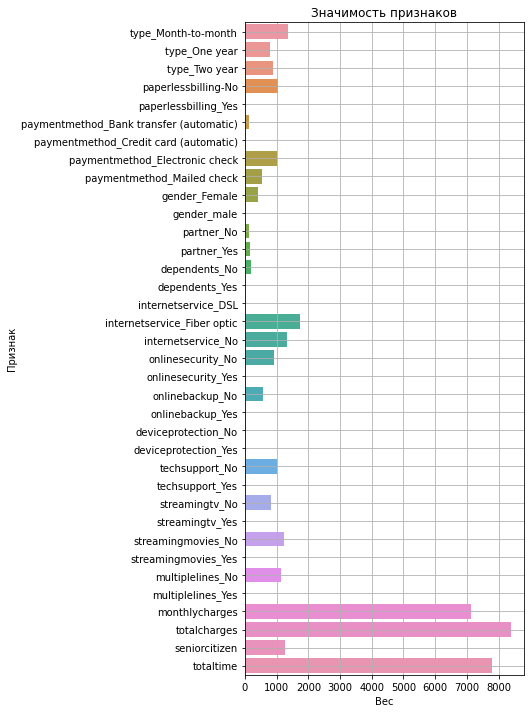

In [ ]:
plt.figure(figsize = (5,12))
sns.barplot(x='feature_importances', y='feature', data=model_feature_importances)
plt.xlabel('Вес')
plt.ylabel('Признак')
plt.title('Значимость признаков')
plt.grid(True)

Как видно, есть наиболее важные три признака в построении прогноза:  
- ежемесячный платеж;
- общие затраты;
- все время пользования услугами.

Проверим, как изменится качество модели, если уберем признаки, которые имеют малый вес

In [ ]:
index_noimportance = model_feature_importances[model_feature_importances['feature_importances'] < 500].index

In [ ]:
X_train_importance_columns = np.delete(X_train_transform_upsample.values, index_noimportance, axis=1)

In [ ]:
model = LGBMClassifier(random_state=4, learning_rate=0.001, n_estimators=10000, num_leaves=5)
model.fit(X_train_importance_columns, y_train_upsample)
cross_val_score(model, 
                X_train_transform_downsample, 
                y_train_downsample, 
                scoring='roc_auc', 
                cv=5).mean()

0.8449558729768125

Качество ухудшилось, поэтому оставим признаки такими, какие были изначально.

## Вывод.
В итоге подбора модели, мы выбрали:  
*LGBMClassifier(learning_rate=0.001, n_estimators=10000, num_leaves=5)*  
Для обучения модели будем использовать увеличение выборки, из-за несбалансированности классов.

Вторичной метрикой является парвильность определения клинетов (accuracy), которые собираются уйти.   
Найдем наиболее оптимальный порог, при котором правильность модели будет наибольшая.

In [ ]:
model = LGBMClassifier(random_state=4, learning_rate=0.001, n_estimators=10000, num_leaves=5)
model.fit(X_train_transform_upsample, y_train_upsample)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=5, objective=None,
               random_state=4, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
res = pd.DataFrame({'prob': model.predict_proba(X_train_transform)[:,1]})
res['prod_round'] = res['prob'].round(2)
threshold = set(res['prod_round'])
res_threshold = pd.DataFrame()
i = 0
for tsh in threshold:
    res_threshold.loc[i, 'threshold'] = tsh
    res_threshold.loc[i, 'accuracy'] = accuracy_score(y_train,
                                (res['prob'] > tsh)*1)
    i += 1
res_threshold[res_threshold['accuracy'] == res_threshold['accuracy'].max()]

,threshold,accuracy
2,0.76,0.818133


Получили наиболее оптимальный порог 0.76.

In [ ]:
model = LGBMClassifier(random_state=4, learning_rate=0.001, n_estimators=10000, num_leaves=5)
model.fit(X_train_transform_upsample, y_train_upsample)
X_test_transform = np.hstack((encoder.transform(general_test[columns_categor]), 
                             scaler.transform(general_test[columns_numeric])))
print('ROC-AUC на тестовой выборке:', 
      roc_auc_score(general_test['target'],
                    model.predict_proba(X_test_transform)[:,1]))

ROC-AUC на тестовой выборке: 0.8402529365173862


In [ ]:
res_test = pd.DataFrame({'prob': model.predict_proba(X_test_transform)[:,1]})
threshold = 0.76
accuracy = accuracy_score(general_test['target'], 
                         (res_test['prob'] >= threshold)*1)
print('Accuracy на тестовой выборке:', accuracy)

Accuracy на тестовой выборке: 0.7938877043354655


# Общий вывод.
Нам требовалось построить модель, которая бы прогнозировала отток клиентов из компании.  
Мы рассмотрели какие у нас данные есть и провели предобработку. Добавили такие признаки как: продолжительность пользования услугами компании в месяцах и средний ежемесячный платеж. 
При анализе данных, мы увидели некоторые закономерности по признакам:  
*type* – большая часть клиентов уходит с договором Month-to-month;  
*paymentmothod* – много клиентов разрывает договор со способом оплаты electronic  check, существующим клиентам с такой системой оплаты можно предложить другую;  
*beginyear* – видна тенденция, что уходят новые клиенты, которые заключили договор в последние годы;  
*partner* – отсутствие мужа/жены сильнее влияет на решение клиента уйти;  
*internetservice* – клиентам, которые пользуются Fiber optic, больше не нравится качество услуг, чем клиентам с DSL;  
*onlinesecurity* – этот параметр, так же сильно влияет на решение клиента уйти, у кого нет защиты намного чаще других разрывают договора;  
*onlinebackup* - отсутствие бекапа так же негативно сказывается на решении клиента остаться;  
*techsupport* - аналогично с выделенной линией тех. поддержки;  
*monthcharges* - так же можно обратить внимание на ежемесячный платеж, в основном уходят те клиенты, у которых ежемесячный платеж в интервале 70-110.  

Нам требовалось построить модель, которая показывает наибольшее значение ROC-AUC. В итоге мы выбрали модель:  
LGBMClassifier(learning_rate=0.001, n_estimators=10000, num_leaves=5) с порогом 0.76 

В итоге получили на тестовой выборке ROC-AUC = 0.84.  
Правильность прогноза составляет 79%